In [11]:
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from datetime import datetime
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt

In [4]:
# loading the data
df = pd.read_csv("loan.csv")
df.shape
df_raw = df.copy()

C:\Users\tamar\AppData\Local\Temp\ipykernel_4644\961585608.py:2: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("loan.csv")


In [6]:
# -------------------------------------------------------------
# Step 1: Create the 3-class target (common for both pipelines)
# -------------------------------------------------------------
def create_target(df):
    """
    Creates the 3-class target:
      - paid_on_time
      - paid_late
      - not_paid

    Also computes helper columns needed to classify paid_late correctly.
    """
    df = df.copy()

    df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y', errors='coerce')
    df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'], format='%b-%Y', errors='coerce')

    # Extract loan term in months
    df['term_months'] = df['term'].astype(str).str.extract(r'(\d+)').astype(float)

    # Approximate expected end date
    df['expected_end'] = df['issue_d'] + pd.to_timedelta(df['term_months'] * 30, unit='D')

    # Late fully paid flag
    df['paid_late_flag'] = (
        (df['loan_status'] == 'Fully Paid') &
        (df['last_pymnt_d'] > df['expected_end'])
    )

    # Build target variable
    df['target_3class'] = 'paid_on_time'
    df.loc[df['paid_late_flag'], 'target_3class'] = 'paid_late'
    df.loc[df['loan_status'].isin(['Charged Off', 'Default']), 'target_3class'] = 'not_paid'
    # Remove '(future leakage + breaks categorical encoding)
    df = df.drop(columns=['next_pymnt_d', 'paid_late_flag', 'last_pymnt_d'], errors='ignore')


    return df[df['target_3class'].notna()].reset_index(drop=True)


In [15]:
# =============================================================
# FULL CLEAN PIPELINE (30 variables clean)
# =============================================================
leakage_columns = [
    'hardship_flag','debt_settlement_flag','total_pymnt','total_rec_prncp',
    'total_rec_int','total_rec_late_fee','last_pymnt_d','last_pymnt_amnt',
    'recoveries','collection_recovery_fee','out_prncp','total_pymnt_inv',
    'out_prncp_inv','loan_status'
]

high_corr_drop_columns = [
    'funded_amnt','funded_amnt_inv','installment',
    'num_rev_tl_bal_gt_0','tot_hi_cred_lim',
    'total_il_high_credit_limit','num_sats'
]

redundant_columns = ['policy_code','disbursement_method','chargeoff_within_12_mths', 'initial_list_status']


def basic_clean1(df):
    """
    First stage of full clean:
    - Remove leakage, high correlation, and redundant columns
    - Drop columns with >90% missing
    - Clean term and emp_length
    - Remove rows with missing target
    """
    clean_df = df.copy()

    cols_to_drop = [c for c in (leakage_columns + high_corr_drop_columns + redundant_columns) 
                    if c in clean_df.columns]
    clean_df = clean_df.drop(columns=cols_to_drop)

    # Drop columns with excessive missingness
    missing_pct = clean_df.isnull().mean() * 100
    high_missing_cols = missing_pct[missing_pct > 90].index.tolist()
    clean_df = clean_df.drop(columns=high_missing_cols)

    # Remove "Not Verified"
    clean_df = clean_df[clean_df['verification_status'] != 'Not Verified']
    clean_df = clean_df.drop(columns=['verification_status'], errors='ignore')

    # Clean term (36/60)
    clean_df['term'] = clean_df['term'].astype(str).str.extract(r'(\d+)').astype(float)

    # Clean employee length
    emp = clean_df['emp_length'].astype(str)
    emp = emp.str.replace('< 1', '0', regex=False)
    clean_df['emp_length'] = emp.str.extract(r'(\d+)').astype(float)

    return clean_df[clean_df['target_3class'].notna()].reset_index(drop=True)


def basic_clean2(df):
    """
    Second stage of full clean:
    - Remove non-informative columns
    - Normalize text columns
    - Create engineered features (purpose_grouped, home_stability, credit_age_years, etc.)
    - Remove raw columns after feature engineering
    """
    clean_df = df.copy()

    # Non-informative
    for col in ['pymnt_plan','zip_code','collections_12_mths_ex_med']:
        clean_df = clean_df.drop(columns=col, errors='ignore')

    # Lowercase text columns
    for col in ['purpose','home_ownership','addr_state','application_type','emp_title']:
        if col in clean_df:
            clean_df[col] = clean_df[col].astype(str).str.lower().str.strip()

    # Grouped purpose variable
    clean_df['purpose_grouped'] = clean_df['purpose'].replace({
        'debt_consolidation':'debt','credit_card':'debt',
        'home_improvement':'housing','house':'housing',
        'small_business':'business',
        'car':'personal','medical':'personal','vacation':'personal','moving':'personal',
        'wedding':'personal','major_purchase':'personal',
        'renewable_energy':'other','educational':'other','other':'other'
    })

    # Home stability
    clean_df['home_stability'] = clean_df['home_ownership'].replace({
        'mortgage':'stable','own':'stable',
        'rent':'unstable','none':'unstable','other':'unstable'
    })

    # Credit age
    years = clean_df['earliest_cr_line'].astype(str).str.extract(r'(\d{4})')[0].astype(float)
    clean_df['credit_age_years'] = datetime.now().year - years

    # Create engineered count-like fields
    clean_df['bad_records_count'] = clean_df[['pub_rec','pub_rec_bankruptcies','tax_liens']].sum(axis=1, min_count=1)
    clean_df['recent_credit_activity'] = (
        clean_df['inq_last_6mths'] + clean_df['num_tl_op_past_12m'] - (clean_df['mths_since_recent_inq']/12)
    )

    clean_df['total_balance_all'] = clean_df['tot_cur_bal'] + clean_df['total_bal_il']
    clean_df['active_credit_accounts'] = clean_df['num_actv_bc_tl'] + clean_df['num_actv_rev_tl']

    # Binary delinquency flag
    clean_df['any_delinquency'] = (
        (clean_df['num_accts_ever_120_pd']>0) |
        (clean_df['num_tl_120dpd_2m']>0) |
        (clean_df['num_tl_90g_dpd_24m']>0) |
        (clean_df['num_tl_30dpd']>0) |
        (clean_df['delinq_2yrs']>0)
    ).astype(int)

    clean_df['is_joint_app'] = clean_df['application_type'].str.contains('joint').astype(int)
    clean_df['has_current_delinquency'] = (clean_df['acc_now_delinq']>0).astype(int)
    clean_df['has_collections'] = (clean_df['tot_coll_amt']>0).astype(int)

    # Drop raw columns after creating engineered features
    columns_to_remove = [
        'purpose','home_ownership','earliest_cr_line','application_type',
        'acc_now_delinq','tot_coll_amt','title','emp_title',
        'addr_state','issue_d','last_credit_pull_d','loan_status',
        'days_late','open_acc','revol_bal','pub_rec','pub_rec_bankruptcies',
        'tax_liens','inq_last_6mths','num_tl_op_past_12m','mths_since_recent_inq',
        'tot_cur_bal','total_bal_il','num_actv_bc_tl','num_actv_rev_tl',
        'num_accts_ever_120_pd','num_tl_120dpd_2m','num_tl_90g_dpd_24m',
        'delinq_2yrs','num_tl_30dpd'
    ]

    clean_df = clean_df.drop(columns=[c for c in columns_to_remove if c in clean_df.columns])

    return clean_df



def basic_clean3(df):
    """
    Final stage of full clean:
    Removes noisy, sparse, redundant, or low-importance features.
    """
    clean_df = df.copy()

    low_importance = [
        'open_act_il','open_il_12m','open_il_24m','open_rv_12m','open_rv_24m',
        'open_acc_6m','inq_fi','total_cu_tl','acc_open_past_24mths'
    ]

    redundant = [
        'num_bc_sats','num_bc_tl','num_il_tl','num_op_rev_tl',
        'num_rev_accts','total_acc'
    ]

    sparse = [
        'mths_since_last_record','mths_since_recent_bc_dlq',
        'mths_since_recent_revol_delinq','percent_bc_gt_75'
    ]

    noisy = [
        'mo_sin_old_il_acct','mo_sin_old_rev_tl_op',
        'mo_sin_rcnt_rev_tl_op','mo_sin_rcnt_tl',
        'mths_since_rcnt_il'
    ]

    optional = [
        'mths_since_last_delinq','avg_cur_bal','max_bal_bc','all_util','il_util',
        'inq_last_12m','pct_tl_nvr_dlq','mort_acc','total_bc_limit','total_acc'
    ]

    to_drop = low_importance + redundant + sparse + noisy + optional
    clean_df = clean_df.drop(columns=[c for c in to_drop if c in clean_df.columns])

    return clean_df



def full_clean(df):
    """
    Applies the full 3-stage cleaning process:
    basic_clean1 → basic_clean2 → basic_clean3
    """
    df1 = basic_clean1(df)
    df2 = basic_clean2(df1)
    df3 = basic_clean3(df2)
    return df3

In [16]:
# =============================================================
# MINIMAL CLEAN PIPELINE
# Extracted from: data minimal clean.py
# =============================================================
def minimal_clean1(df):
    """
    Minimal clean:
    - Remove leakage
    - Remove columns with >90% missing
    - Remove one feature from each high-correlation (>0.95) pair
    """
    clean_df = df.copy()

    leakage = [
        'hardship_flag','debt_settlement_flag','total_pymnt','total_rec_prncp',
        'total_rec_int','total_rec_late_fee','last_pymnt_d','last_pymnt_amnt',
        'recoveries','collection_recovery_fee','out_prncp','total_pymnt_inv',
        'out_prncp_inv','loan_status','paid_late_flag'
    ]
    clean_df = clean_df.drop(columns=[c for c in leakage if c in clean_df.columns])

    # Drop >90% missing
    missing_pct = clean_df.isnull().mean() * 100
    high_missing = missing_pct[missing_pct > 90].index.tolist()
    clean_df = clean_df.drop(columns=high_missing)

    # High-correlation removal
    num = clean_df.select_dtypes(include='number').columns
    if len(num) > 1:
        corr = clean_df[num].corr().abs()
        to_drop = set()

        missing = clean_df[num].isnull().mean()
        var = clean_df[num].var()

        for i, c1 in enumerate(num):
            for j, c2 in enumerate(num):
                if j <= i:
                    continue
                if corr.loc[c1, c2] > 0.95:
                    if missing[c1] > missing[c2]:
                        to_drop.add(c1)
                    elif missing[c2] > missing[c1]:
                        to_drop.add(c2)
                    else:
                        to_drop.add(c1 if var[c1] < var[c2] else c2)

        clean_df = clean_df.drop(columns=list(to_drop))

    return clean_df



def minimal_clean2(df):
    """
    Additional minimal cleaning:
    Convert term and emp_length to numeric, extract issue year.
    """
    clean_df = df.copy()

    clean_df['term'] = clean_df['term'].astype(str).str.extract(r'(\d+)').astype(float)

    emp = clean_df['emp_length'].astype(str)
    emp = emp.str.replace('< 1', '0', regex=False)
    clean_df['emp_length'] = emp.str.extract(r'(\d+)').astype(float)

    clean_df['issue_year'] = clean_df['issue_d'].astype(str).str.extract(r'(\d{4})')[0].astype(float)

    return clean_df



def minimal_clean(df):
    """
    Applies minimal_clean1 → minimal_clean2
    """
    df1 = minimal_clean1(df)
    df2 = minimal_clean2(df1)
    return df2[df2["target_3class"].notna()].reset_index(drop=True)

In [ ]:
def make_preprocess(df):
    """
    Builds preprocessing:
      - Time since event columns (mths_since_*):
          * Impute missing with 0 (interpreted as 'no event')
          * Add missing indicator
          * Scale
      - Other numeric columns:
          * Impute missing with median
          * Add missing indicator
          * Scale
      - Categorical columns:
          * Impute missing with string 'missing'
          * One-hot encode (missing becomes category)
    """

    # 1. Identify column groups
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    time_cols = [col for col in numeric_cols if col.startswith("mths_since_")]
    num_regular = list(set(numeric_cols) - set(time_cols))
    categorical_cols = df.select_dtypes(include=['object', 'bool']).columns.tolist()

    # 2. Pipelines
    time_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value=0, add_indicator=True)),
        ("scaler", StandardScaler())
    ])

    numeric_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
        ("scaler", StandardScaler())
    ])

    categorical_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])

    # 3. Combine all
    transformer = ColumnTransformer(
        transformers=[
            ("time", time_pipeline, time_cols),
            ("num", numeric_pipeline, num_regular),
            ("cat", categorical_pipeline, categorical_cols),
        ],
        remainder="drop"
    )

    return transformer

In [15]:
def build_model_pipeline(preprocess):
    """
    Combines preprocessing + RandomForest classifier into a single Pipeline.
    """
    model = RandomForestClassifier(n_estimators=300, random_state=42)

    pipe = Pipeline([
        ("preprocess", preprocess),
        ("clf", model)
    ])

    return pipe

In [16]:
def run_experiment(df, title, model_type):
    """
    Runs training + test split + preprocessing + model training.
    model_type: "random_forest", "logistic", "xgboost"
    """
    print(f"\n=== Running: {title} ({model_type}) ===")

    # Split into features and target
    X = df.drop(columns=["target_3class"])
    y = df["target_3class"]
    
        # Convert target to numeric for XGBoost
    if model_type == "xgboost":
        y = y.astype("category").cat.codes

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        stratify=y,
        random_state=42,
    )


    # Build preprocessing based only on the feature matrix
    preprocess = make_preprocess(X_train)

    # Choose model
    if model_type == "random_forest":
        model = RandomForestClassifier(
            n_estimators=650,
            max_depth=None,
            min_samples_split=7,
            min_samples_leaf=1,
            max_features=0.5,
            n_jobs=-1,
            random_state=42
        )

    elif model_type == "xgboost":
        model = XGBClassifier(
            n_estimators=550,
            learning_rate=0.01,
            max_depth=8,
            subsample=0.7,
            colsample_bytree=0.7,
            min_child_weight=1,
            gamma=0.6,
            eval_metric="logloss",
            tree_method="hist"   # FAST + GPU compatible
        )

    elif model_type == "logistic":
        model = LogisticRegression(
            penalty='l2',
            max_iter=2000,
            l1_ratio=0.8,
            class_weight="balanced",
            C=0.05
        )

    # Create pipeline
    pipe = Pipeline([
        ("pre", preprocess),
        ("model", model)
    ])

    # Fit
    pipe.fit(X_train, y_train)

    # ---------- Evaluation ----------
    # תחזיות על קבוצת ה-test
    y_pred = pipe.predict(X_test)

    # 1. Accuracy – אחוז הדוגמאות שנחזו נכון
    acc = accuracy_score(y_test, y_pred)

    # 2. Macro F1 – ממוצע F1 לכל המחלקות
    macro_f1 = f1_score(y_test, y_pred, average="macro")

    print("Accuracy:", acc)
    print("Macro F1:", macro_f1)

    # 3. Confusion Matrix
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # 4. Classification Report – Precision / Recall / F1 לכל מחלקה
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return acc, pipe

In [ ]:
# =============================================================
# Run 3 models on both Full and Minimal datasets
# =============================================================
df_with_target = create_target(df_raw)

df_sample = df_with_target.sample(100000, random_state=42)

df_full_sample = full_clean(df_sample.copy())
df_minimal_sample = minimal_clean(df_sample.copy())


models = ["random_forest", "xgboost", "logistic"]

results = {}

for model_name in models:
    print("\n=============================================================")
    print(f"MODEL: {model_name.upper()}")
    print("=============================================================")

    # ---- FULL CLEAN ----
    acc_full, model_full = run_experiment(
        df_full_sample,
        f"Full Clean Sample - {model_name}",
        model_type=model_name
    )

    # ---- MINIMAL CLEAN ----
    acc_minimal, model_minimal = run_experiment(
        df_minimal_sample,
        f"Minimal Clean Sample - {model_name}",
        model_type=model_name
    )

    # Save results
    results[(model_name, "full")] = acc_full
    results[(model_name, "minimal")] = acc_minimal


# =============================================================
# Print Summary Table
# =============================================================
print("\n\n==================== SUMMARY ====================\n")
print("{:<20} {:<15} {:<15}".format("Model", "Full Clean", "Minimal Clean"))
print("-" * 50)

for model_name in models:
    print("{:<20} {:<15.4f} {:<15.4f}".format(
        model_name,
        results[(model_name, "full")],
        results[(model_name, "minimal")]
    ))

### handling outliers


In [17]:
full_df = create_target(df_raw)

minimal_clean_full_df = minimal_clean(full_df)

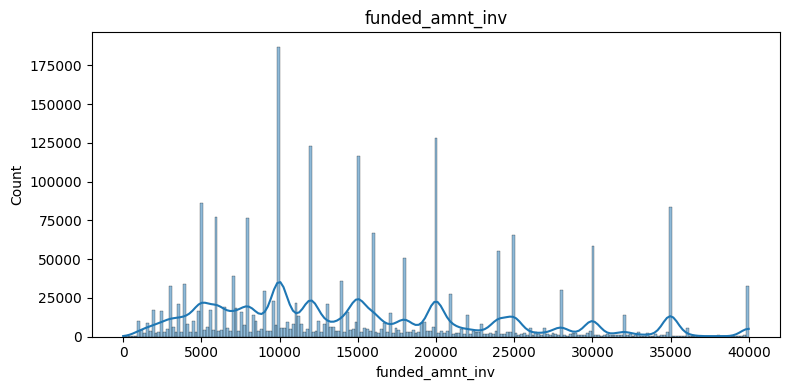

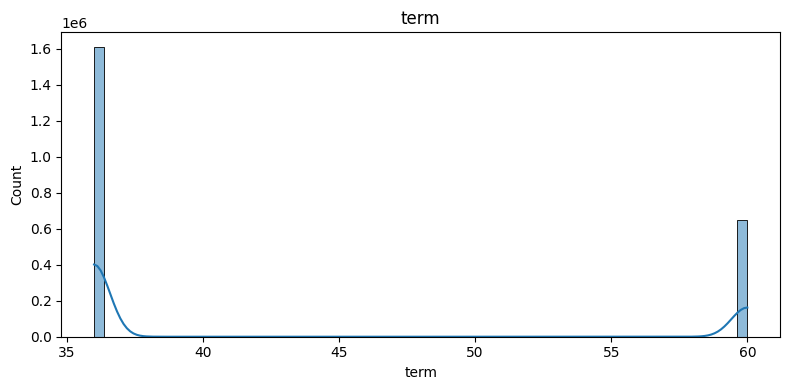

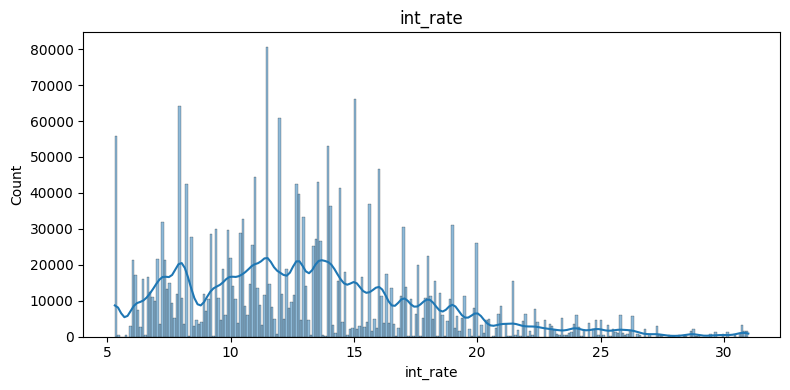

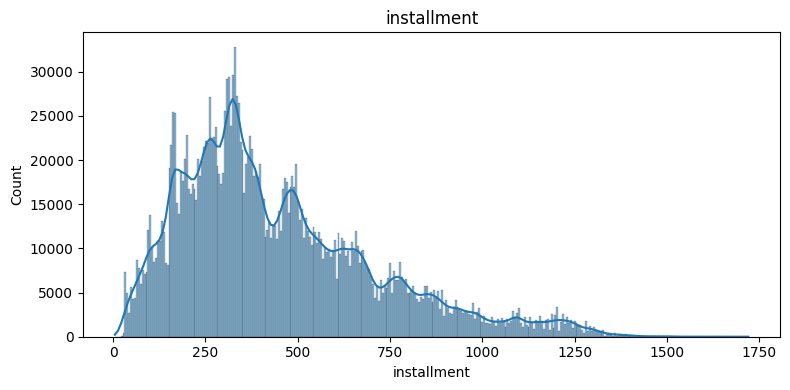

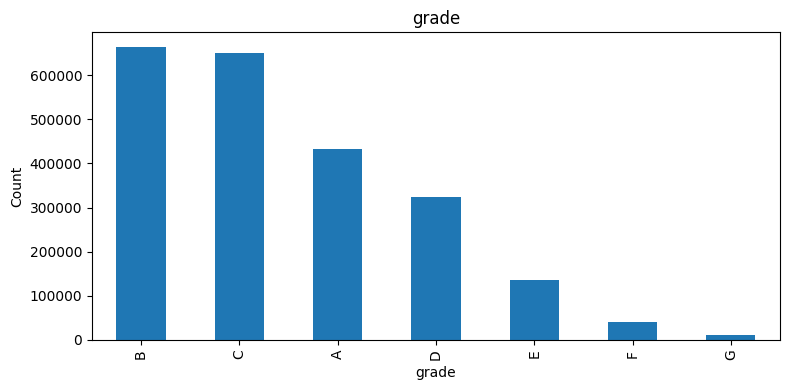

Skipping 'sub_grade' (too many categories: 35)
Skipping 'emp_title' (too many categories: 512694)


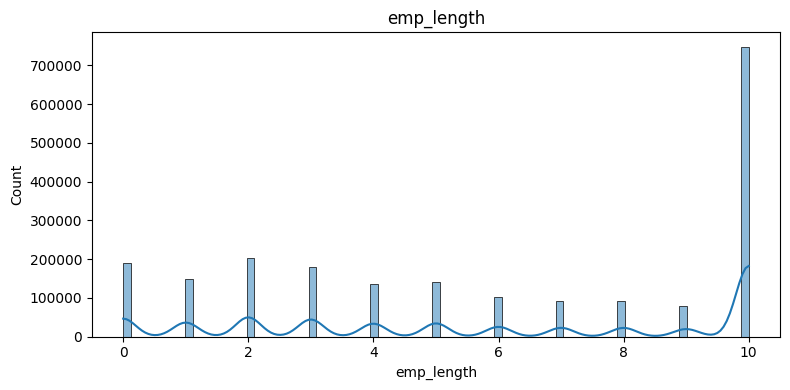

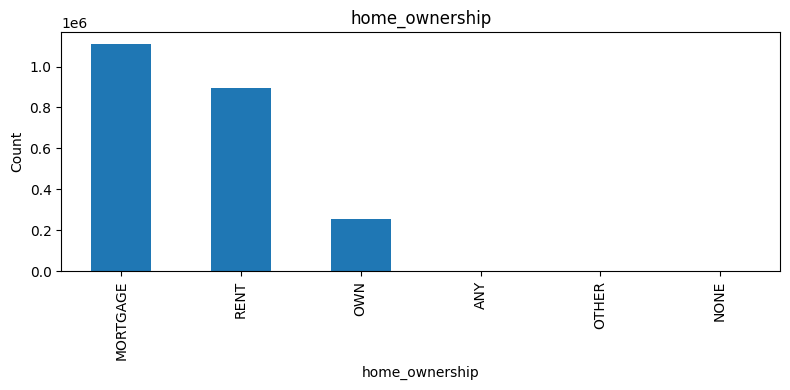

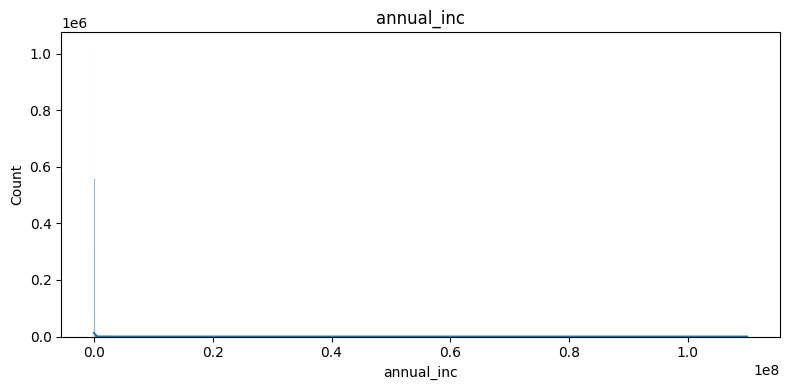

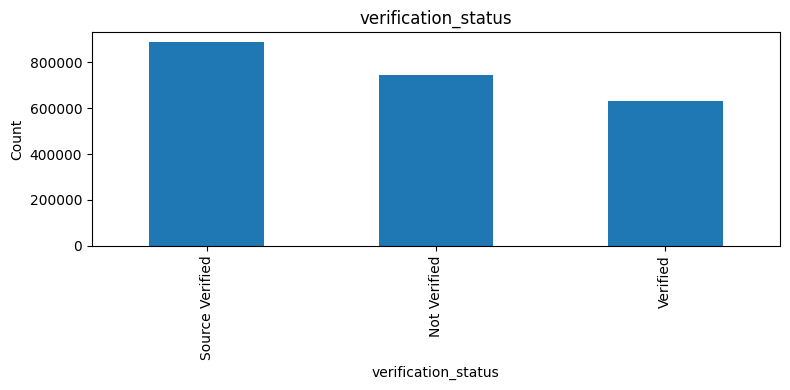

Skipping 'issue_d' (too many categories: 139)


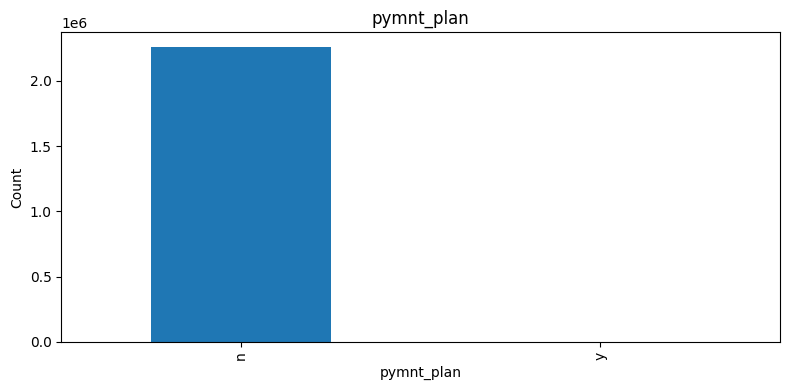

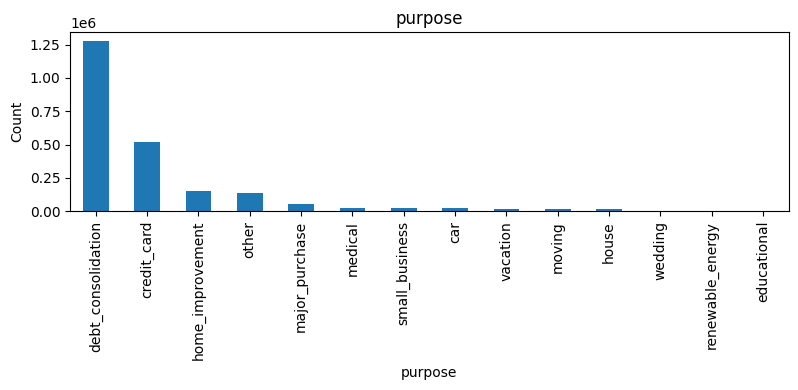

Skipping 'title' (too many categories: 63154)
Skipping 'zip_code' (too many categories: 956)
Skipping 'addr_state' (too many categories: 51)


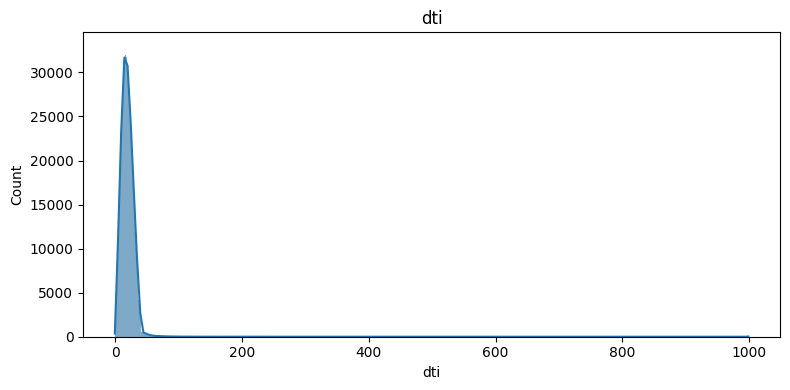

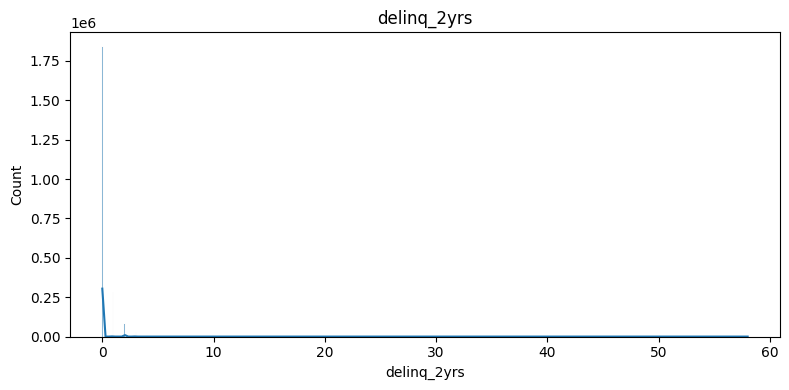

Skipping 'earliest_cr_line' (too many categories: 754)


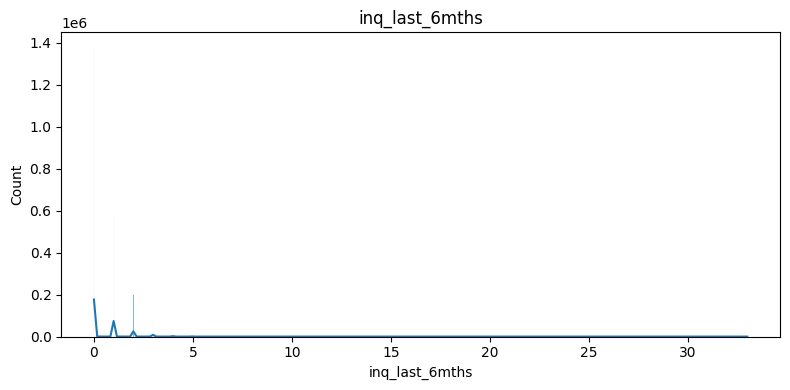

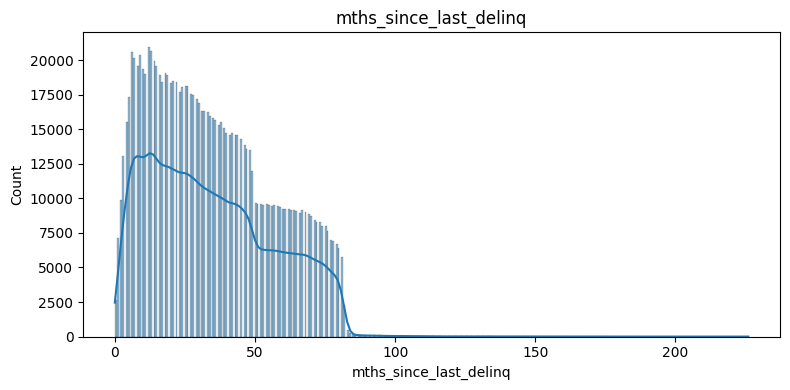

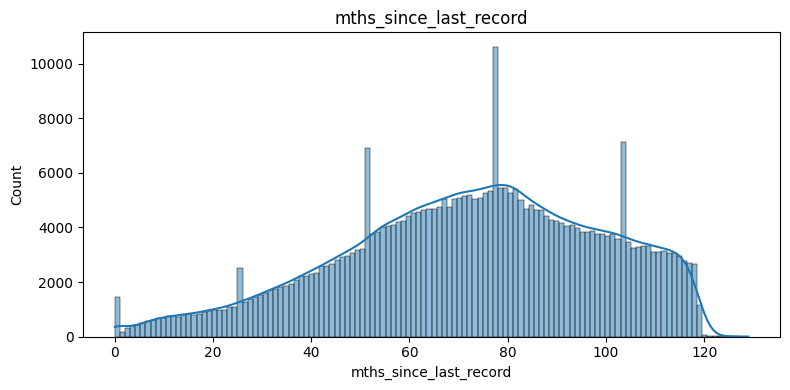

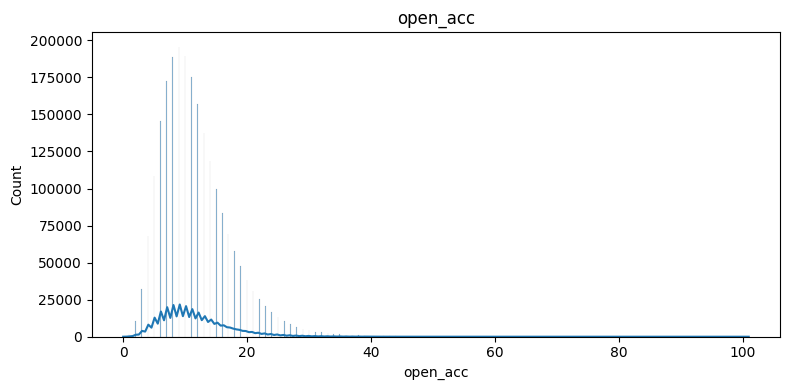

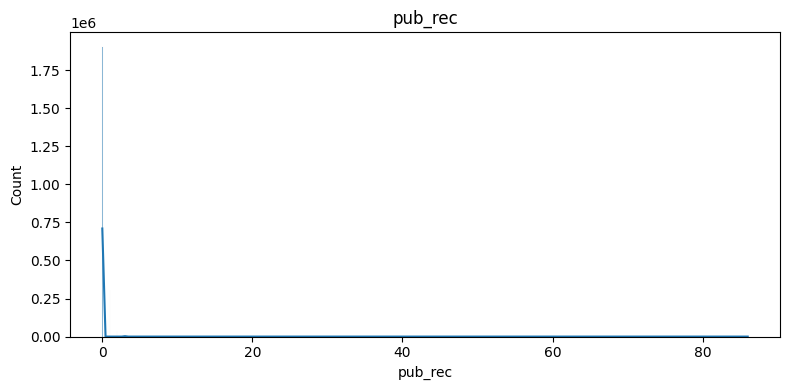

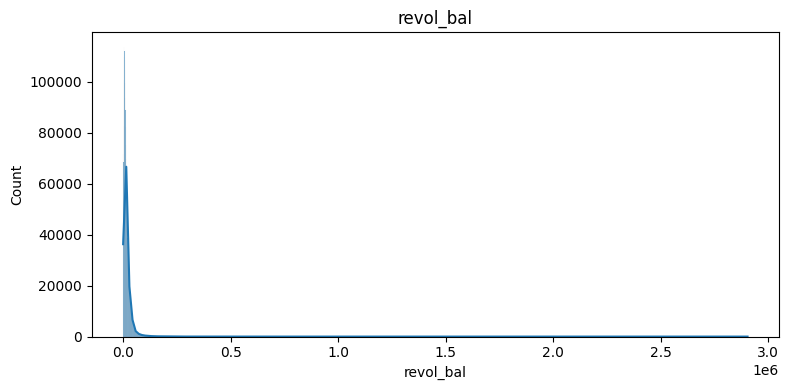

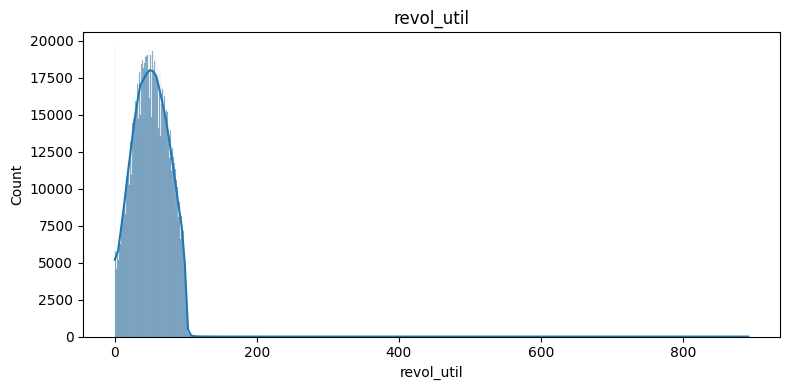

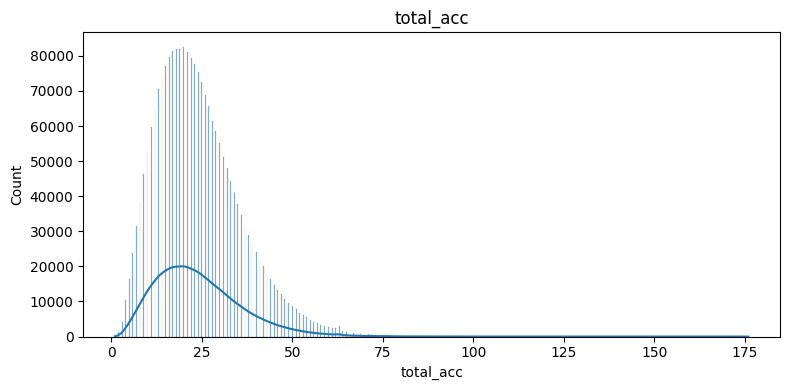

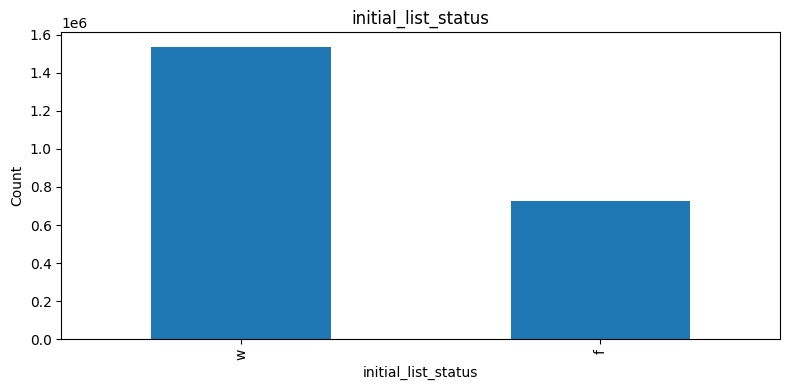

Skipping 'last_credit_pull_d' (too many categories: 140)


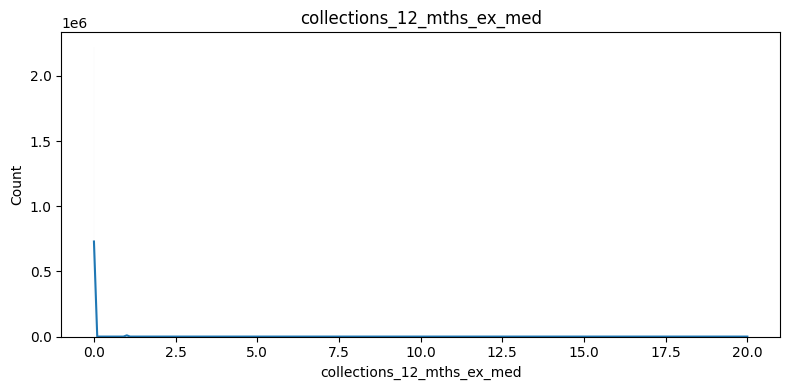

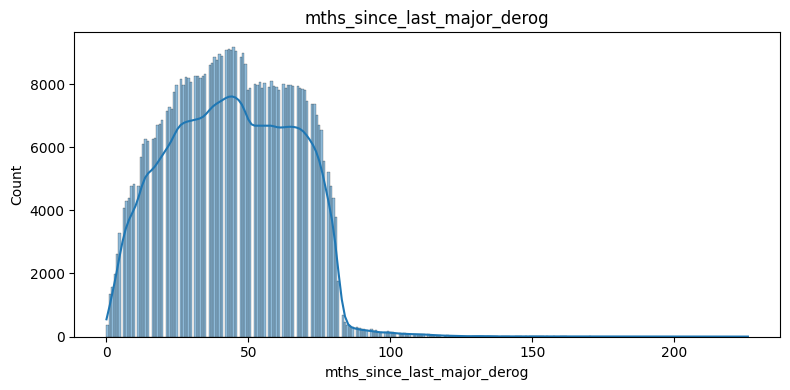

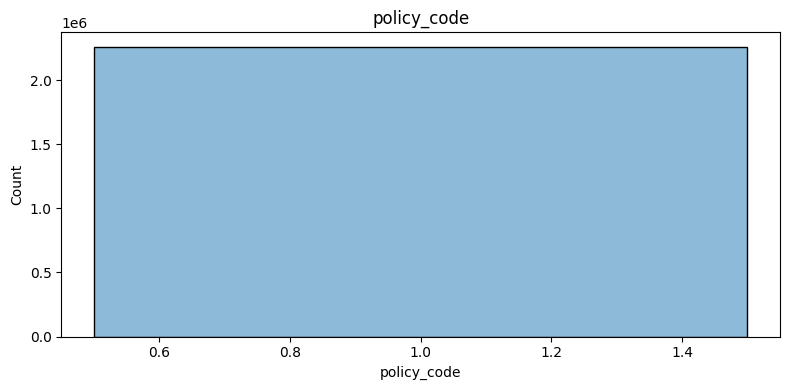

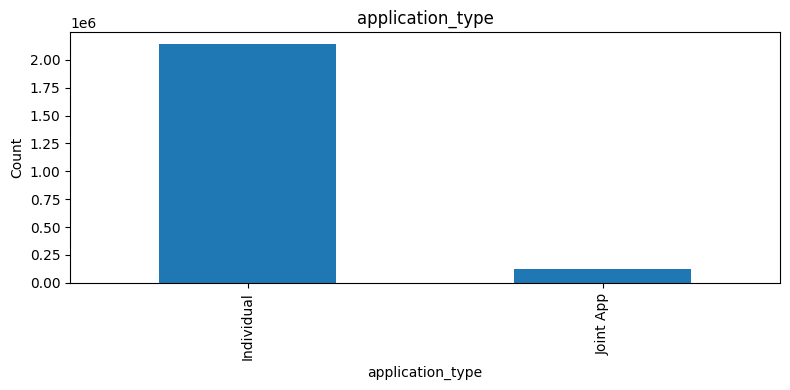

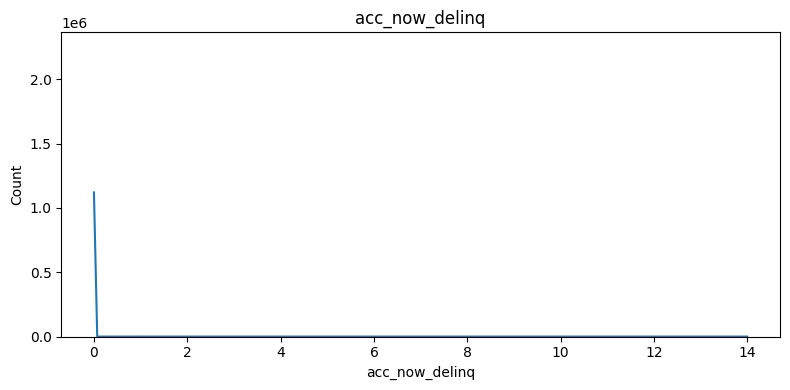

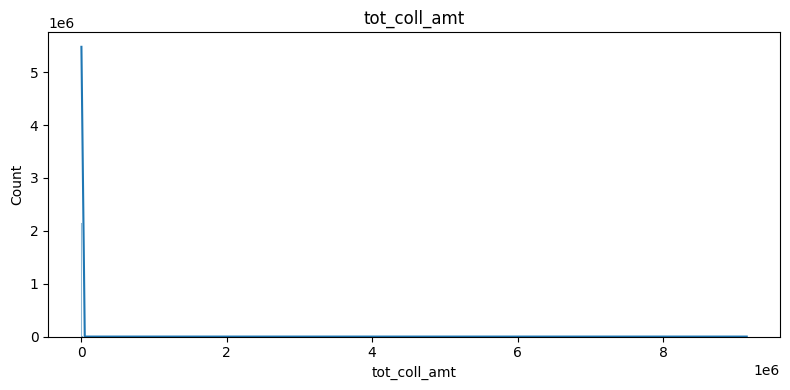

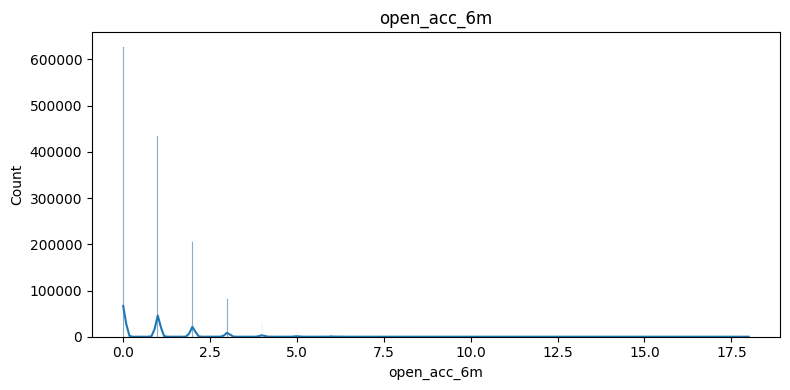

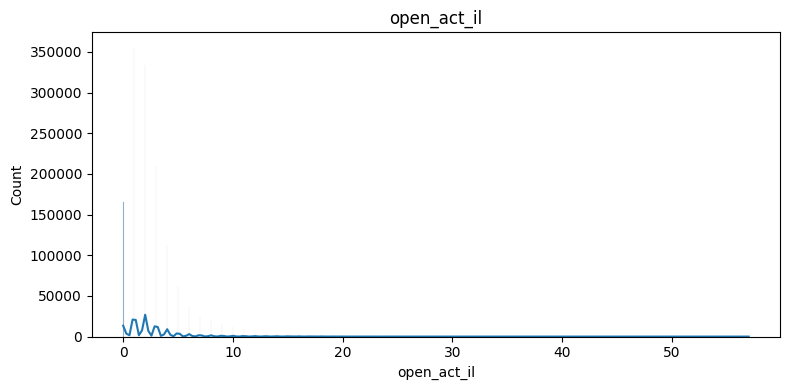

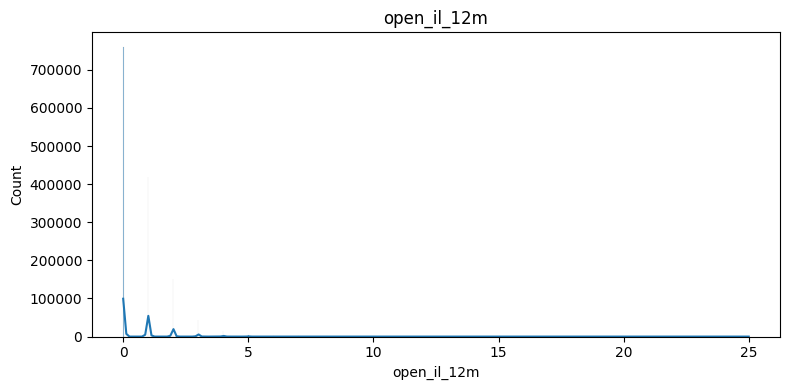

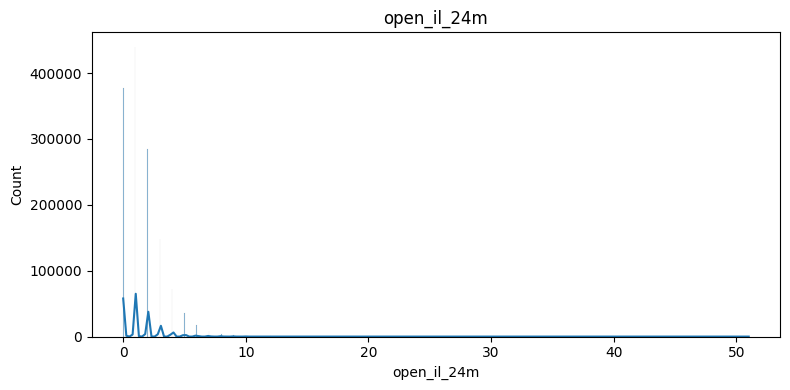

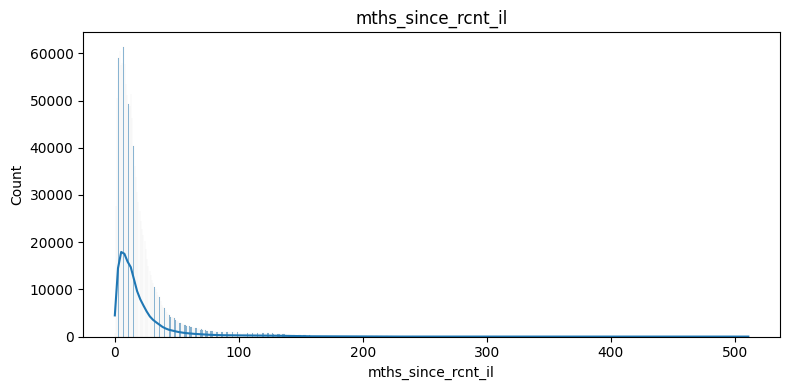

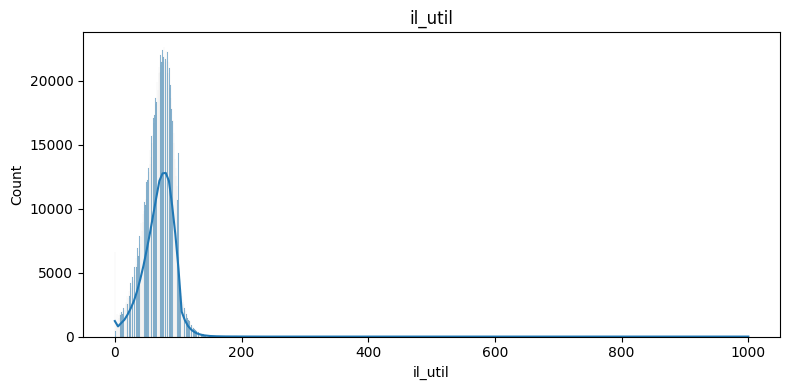

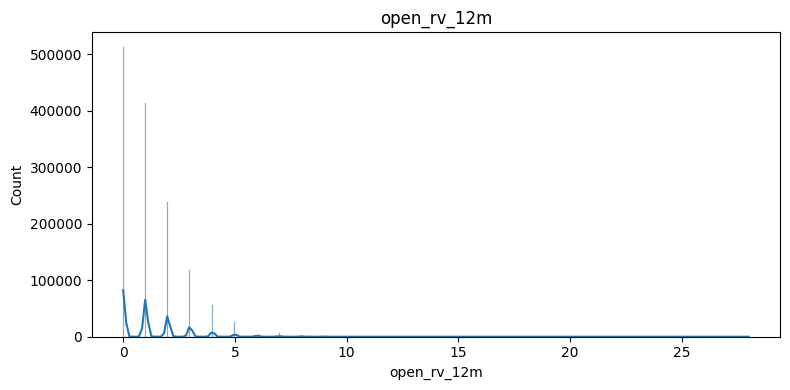

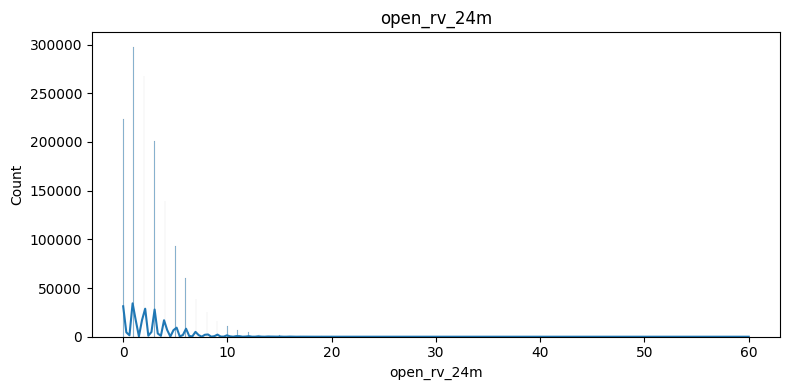

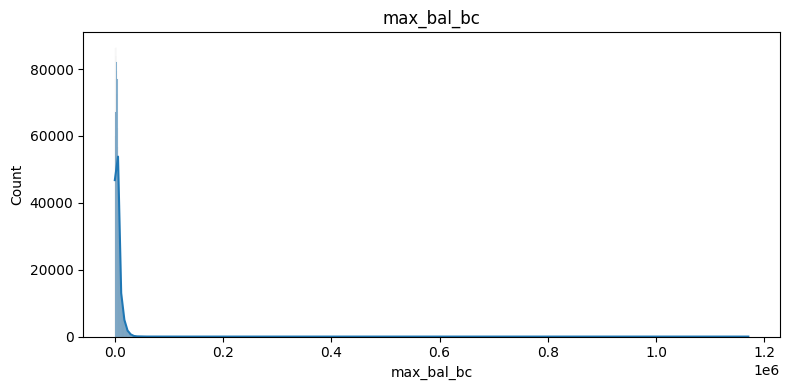

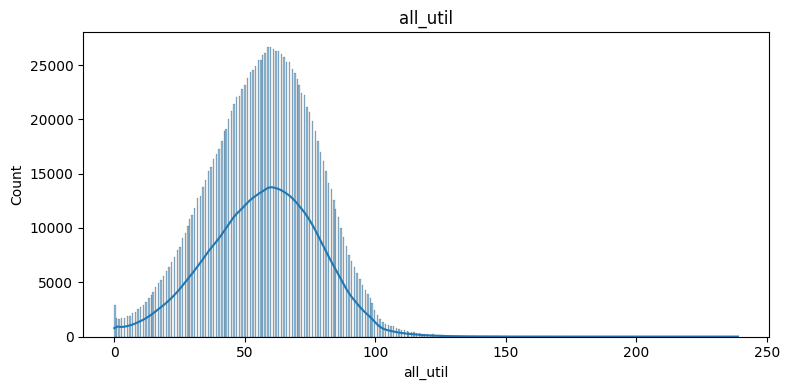

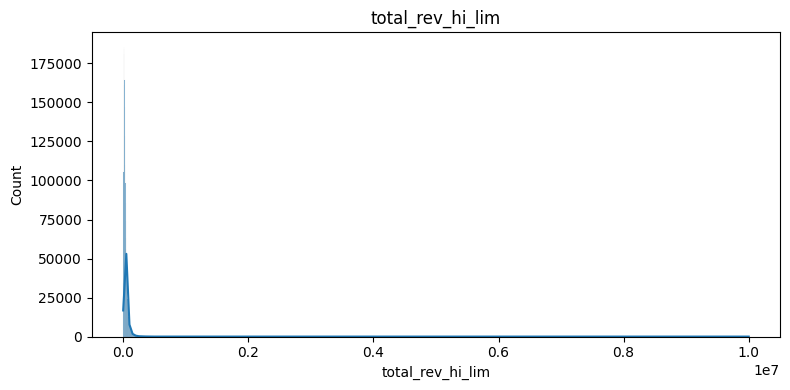

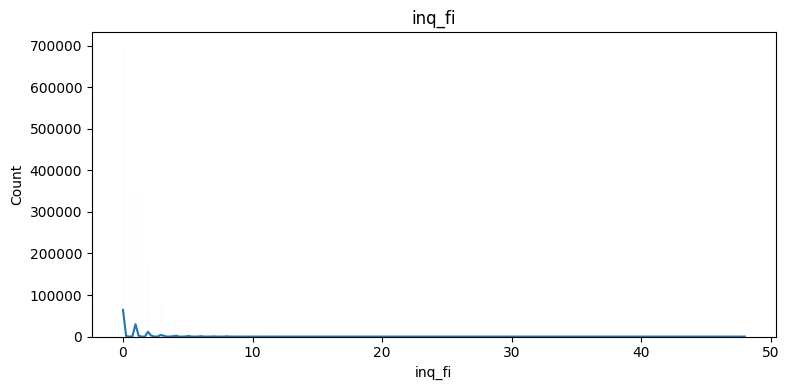

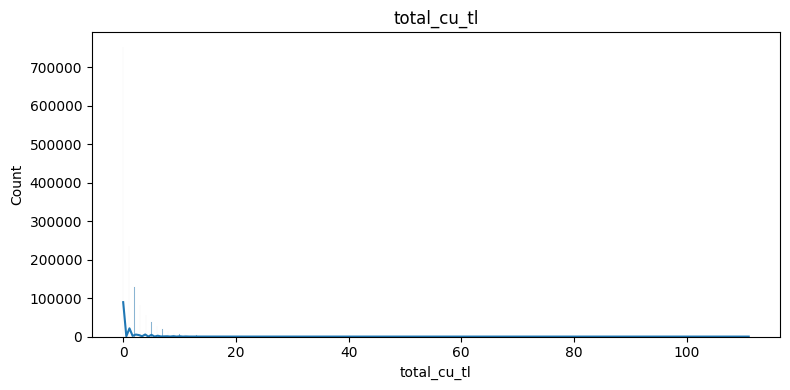

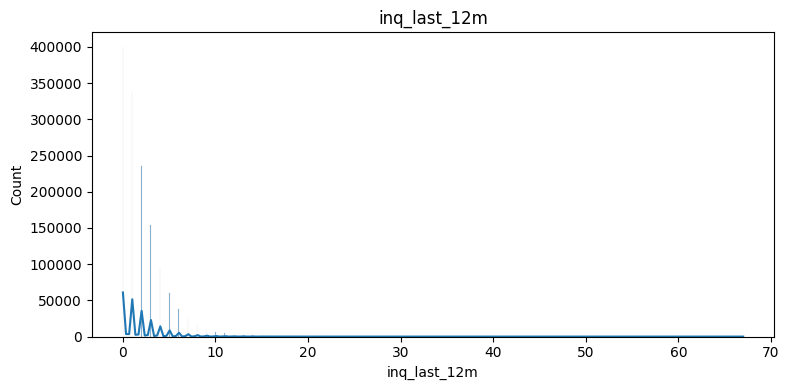

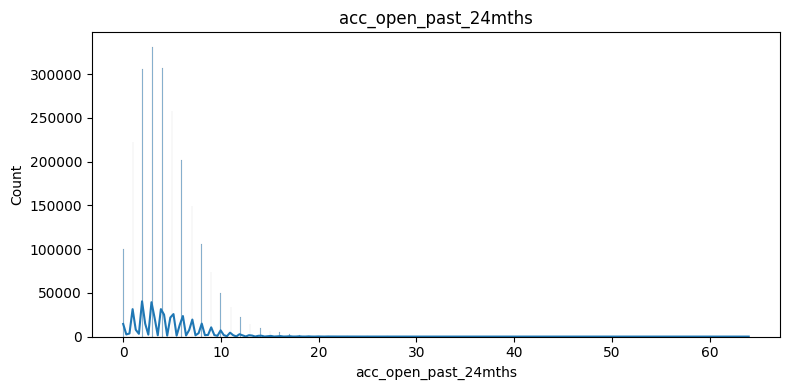

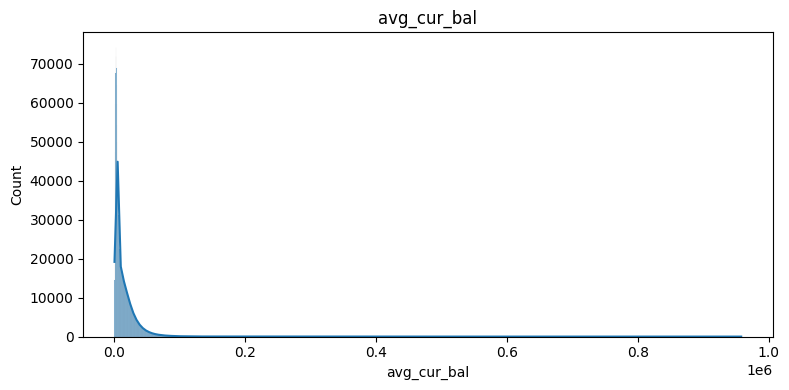

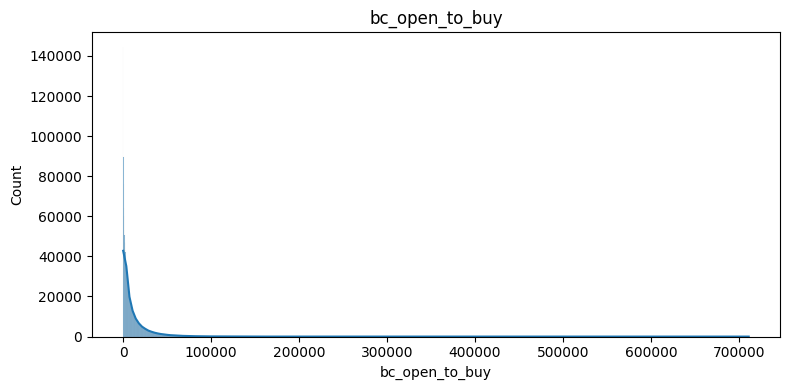

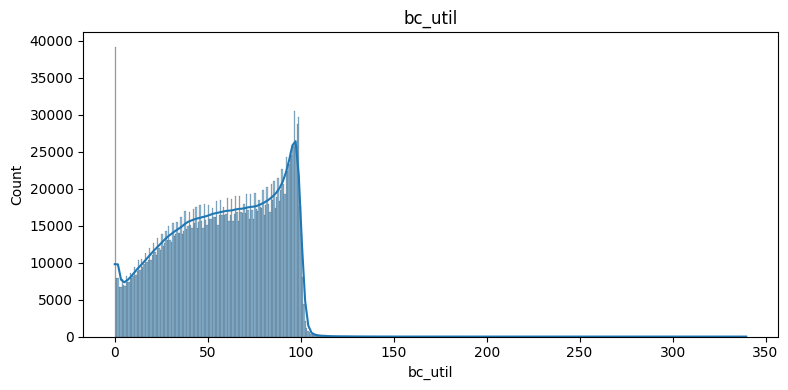

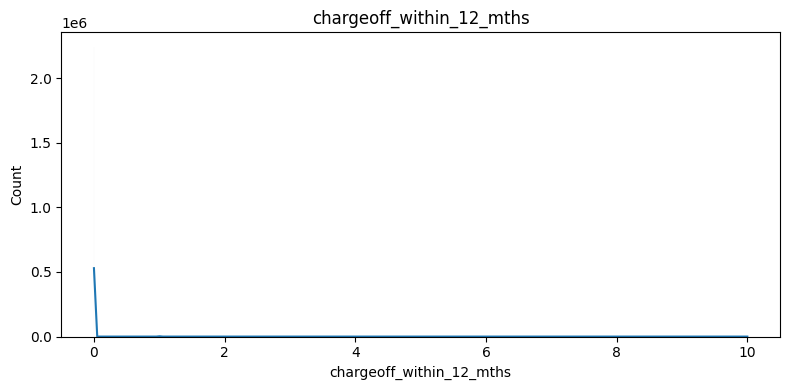

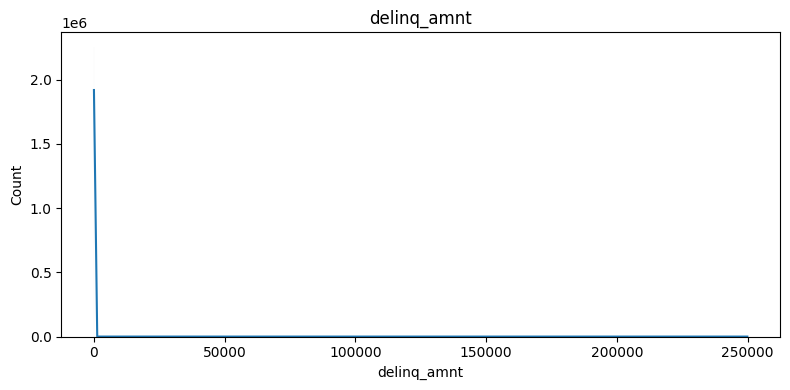

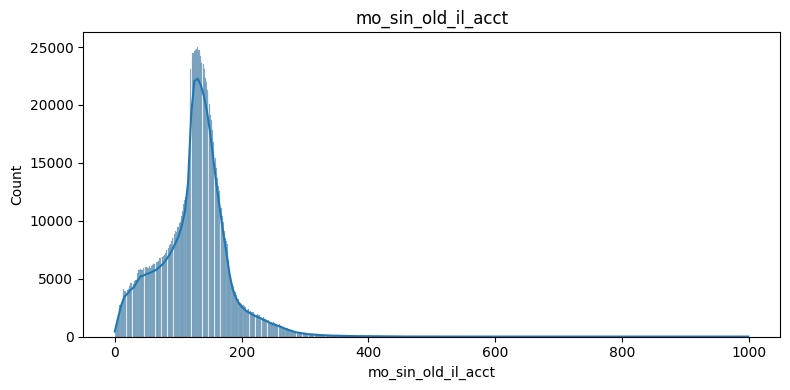

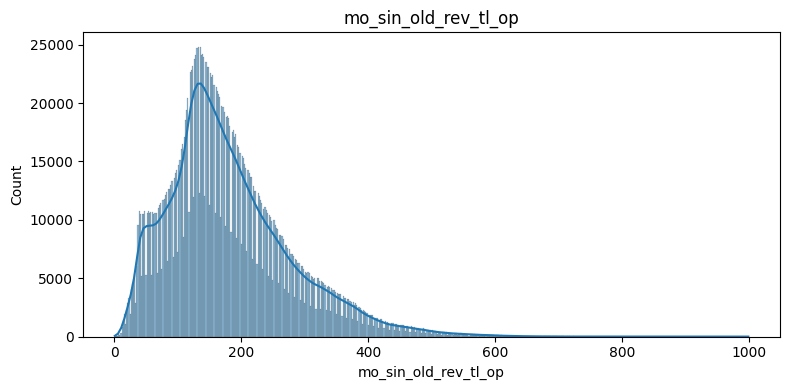

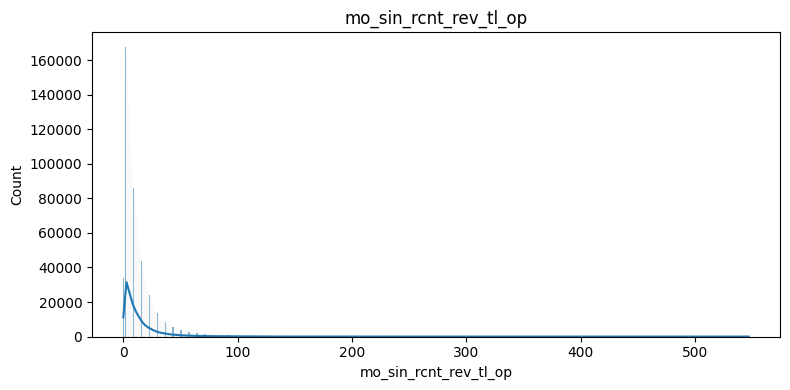

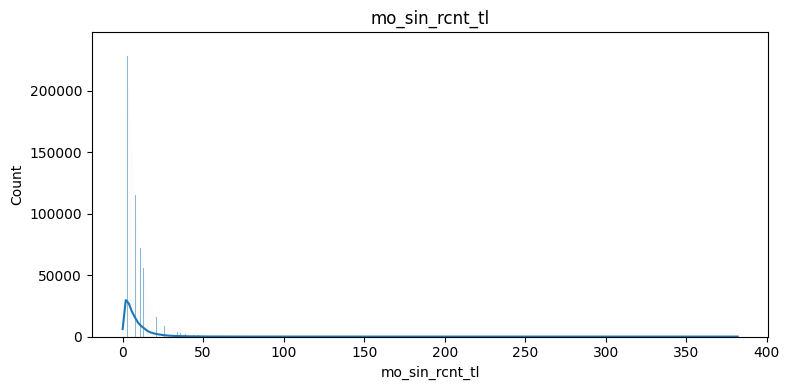

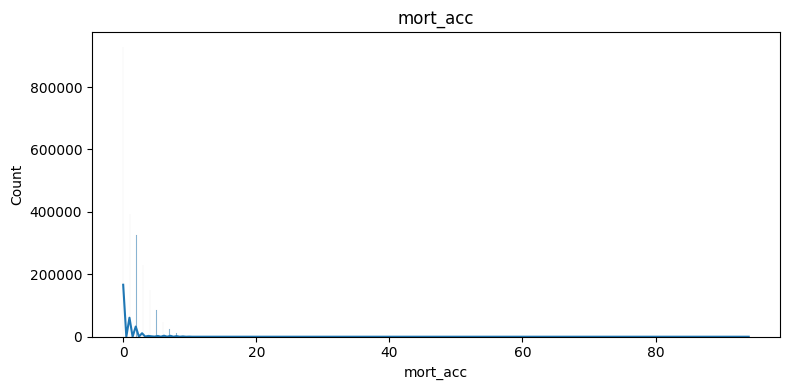

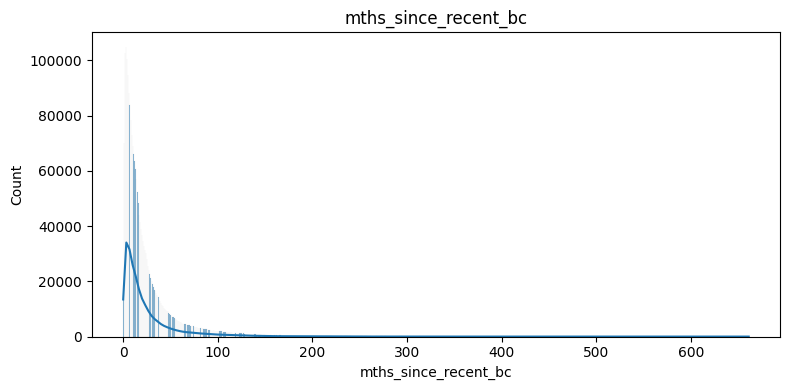

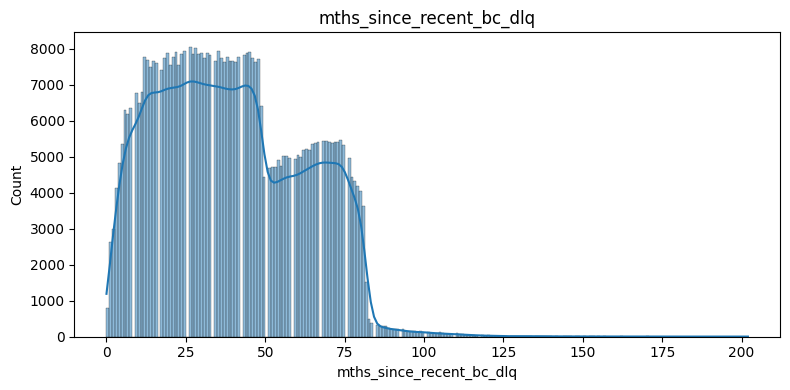

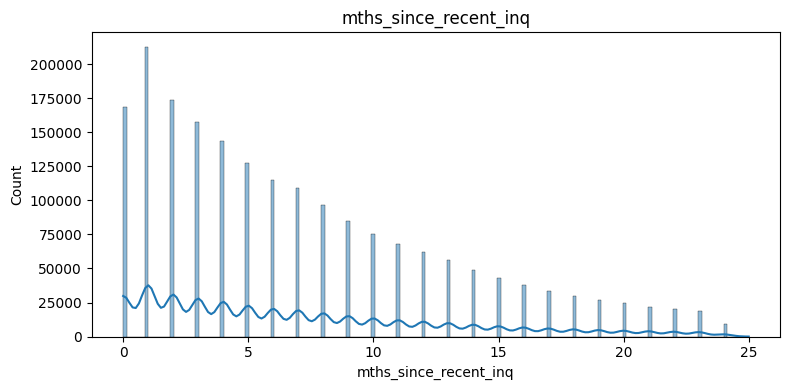

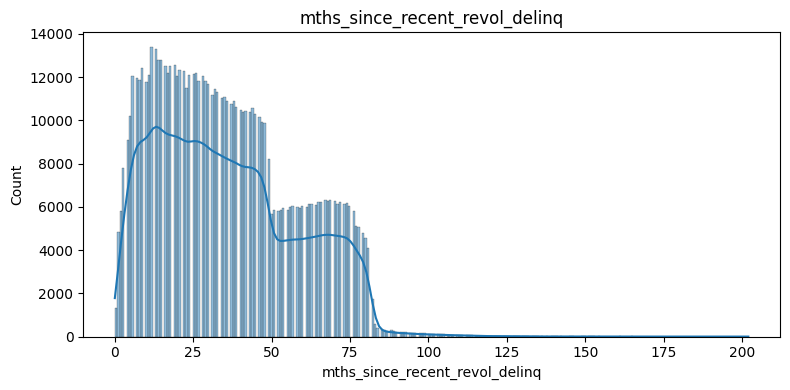

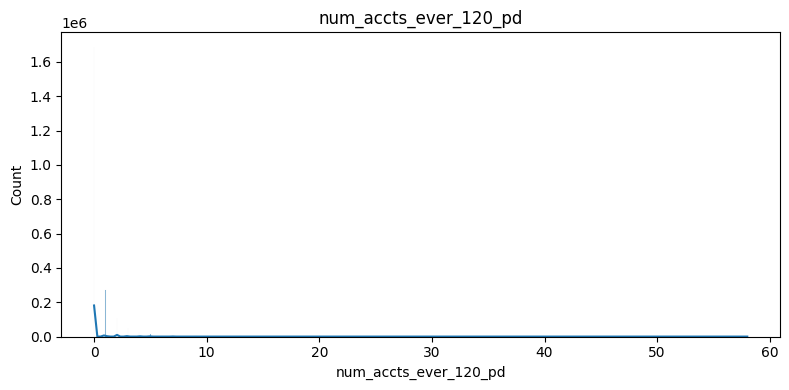

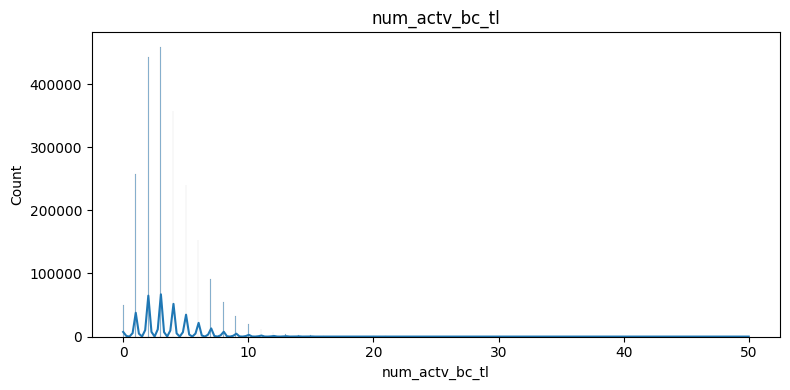

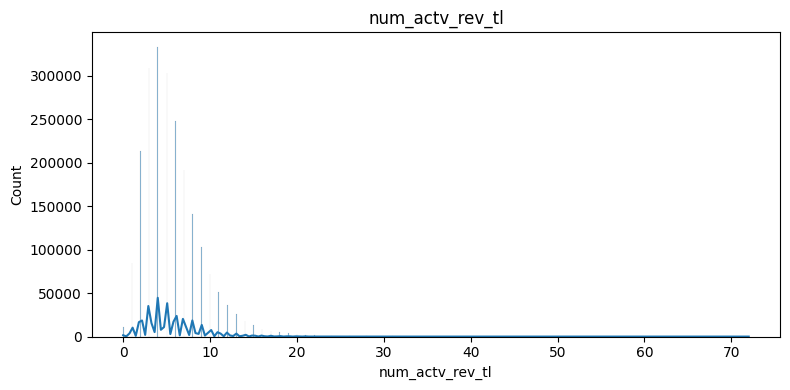

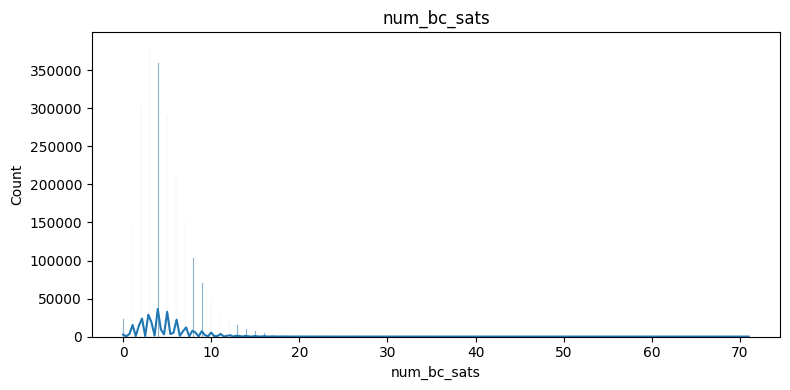

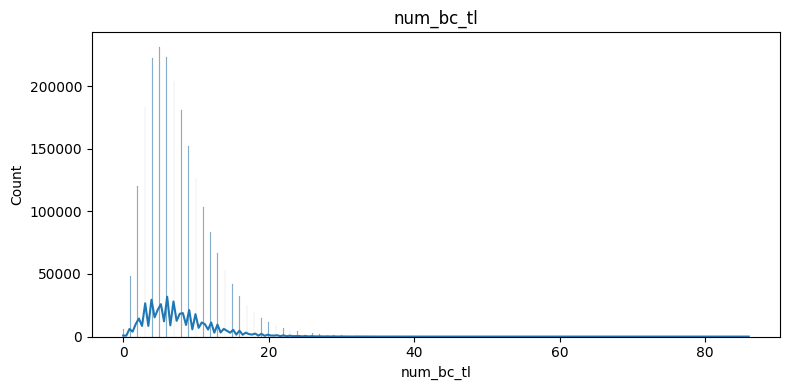

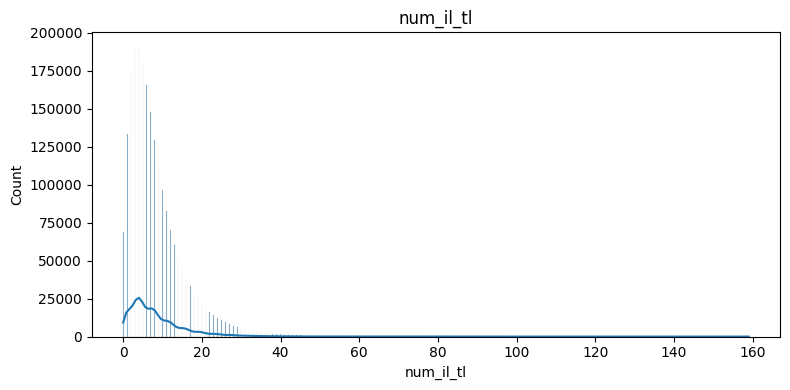

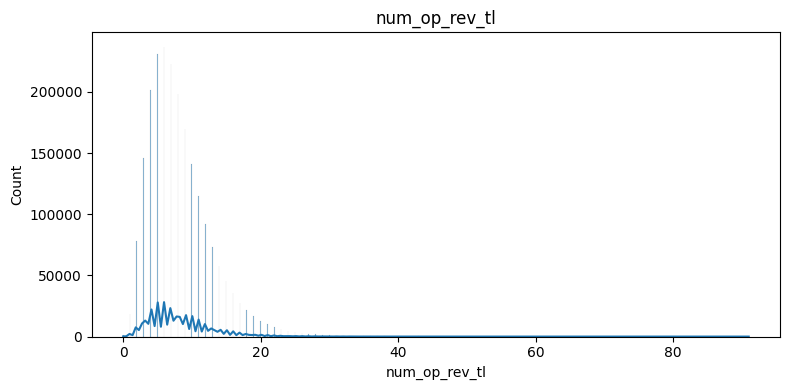

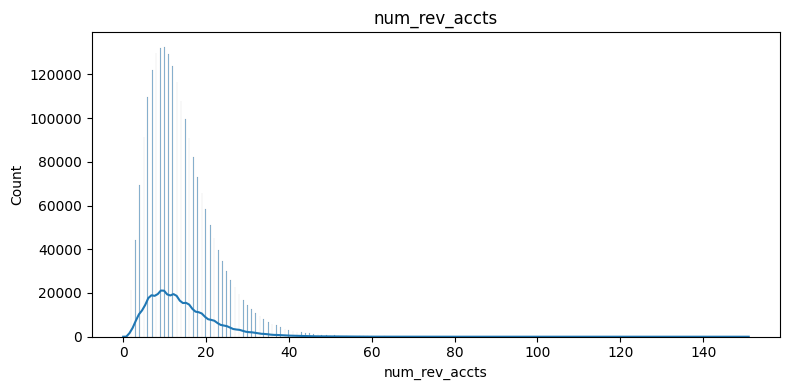

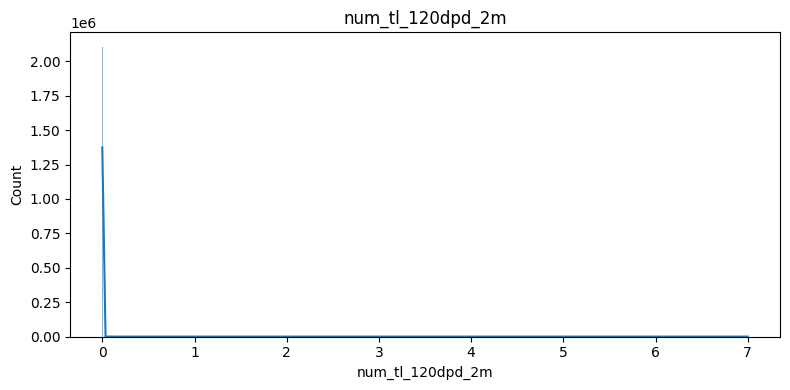

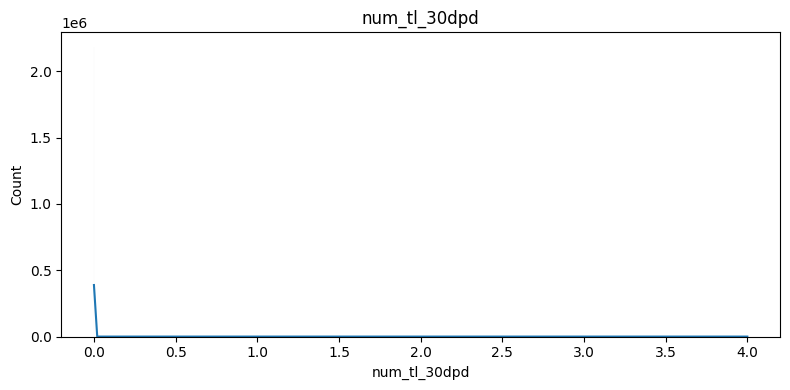

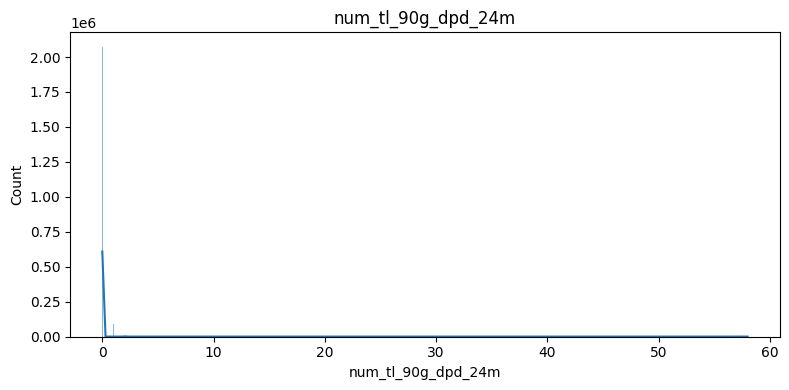

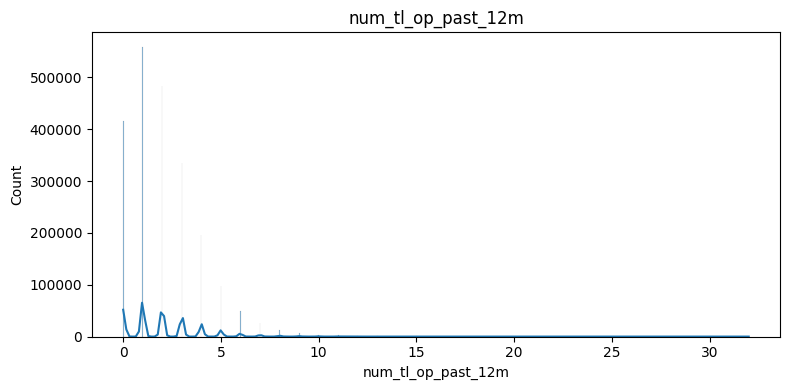

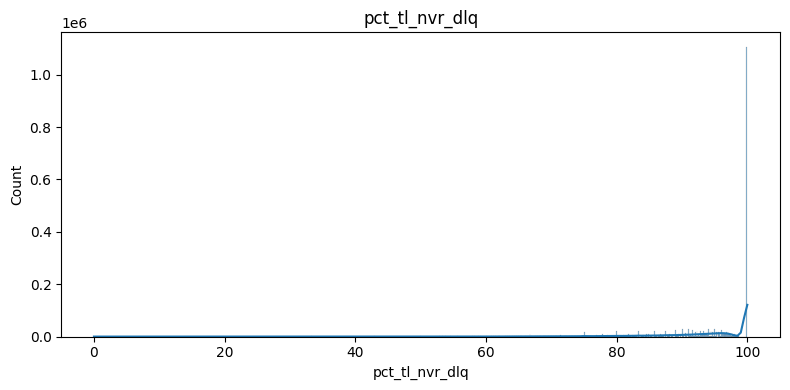

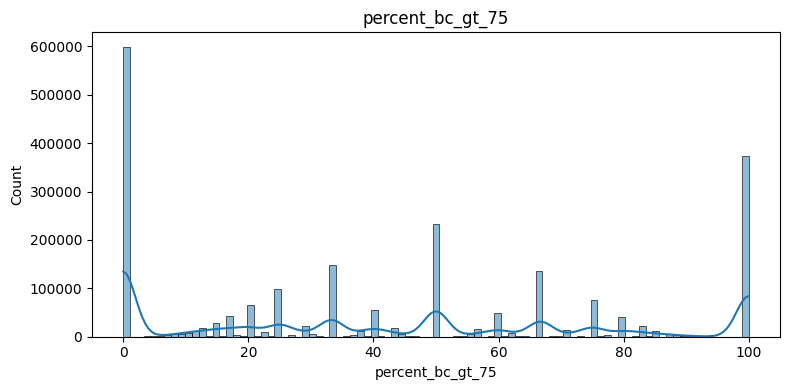

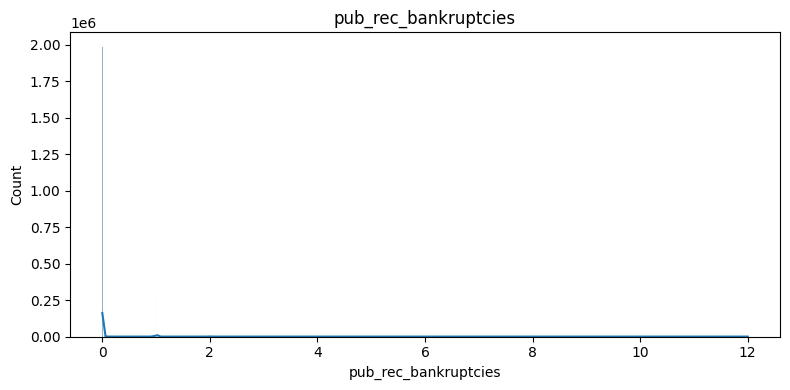

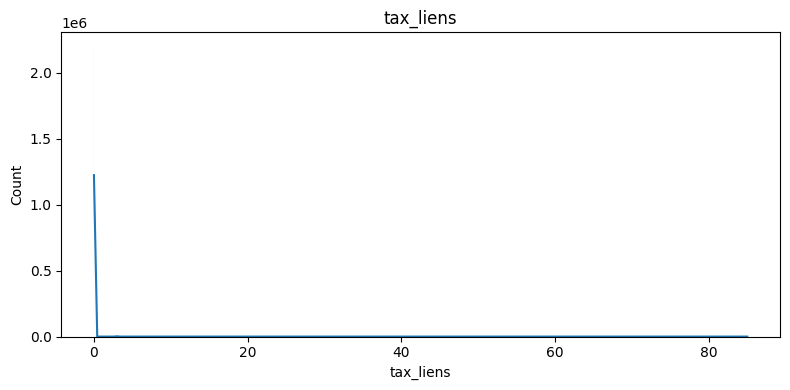

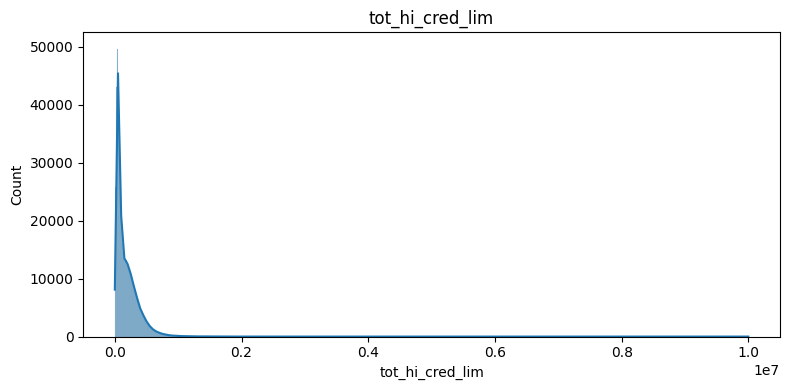

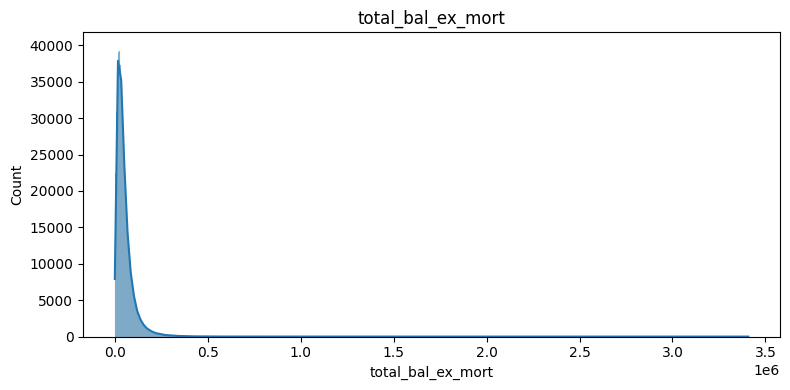

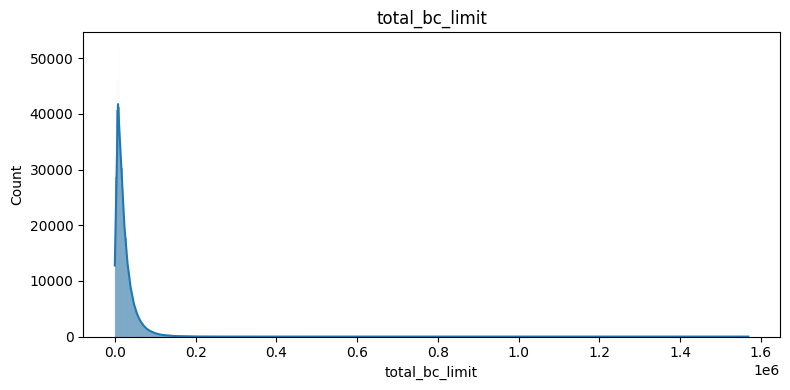

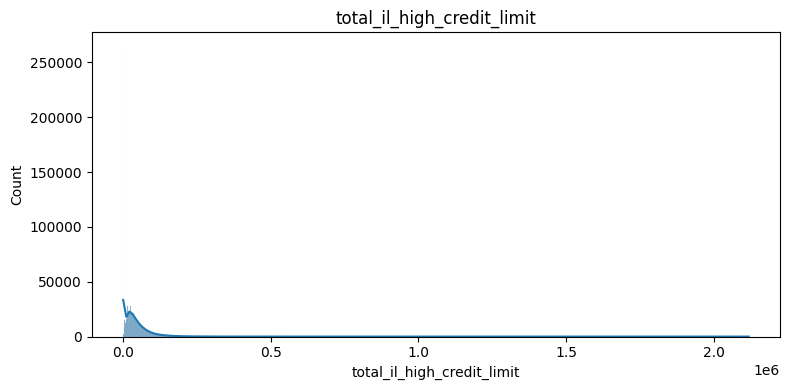

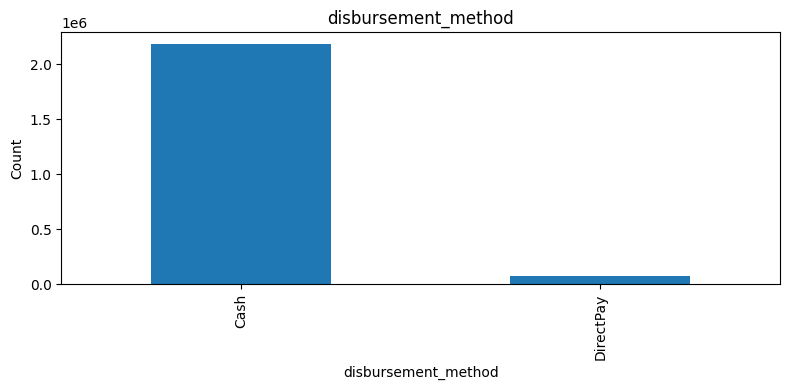

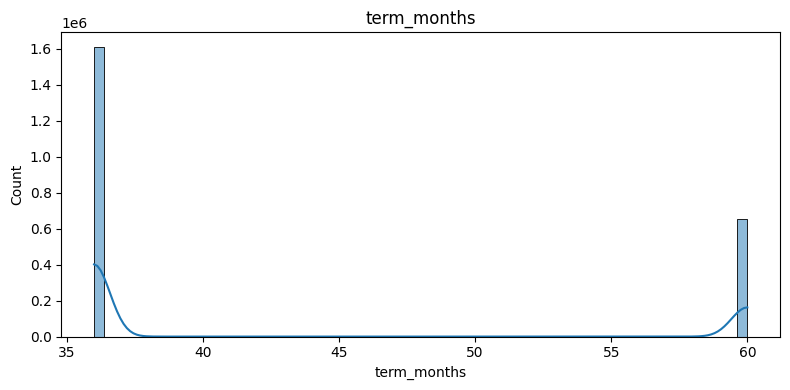

Skipping 'expected_end' (too many categories: 243)


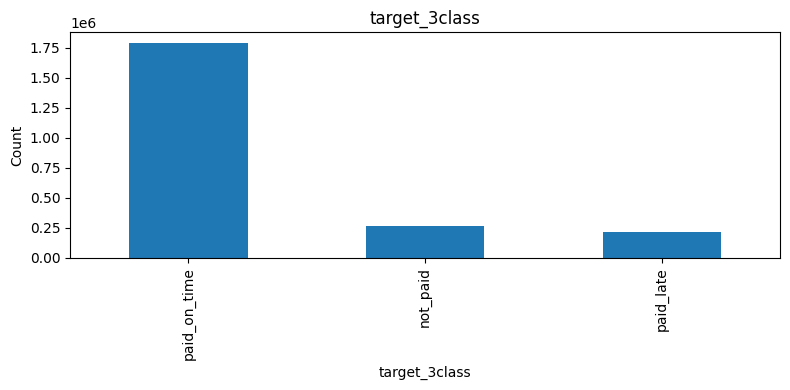

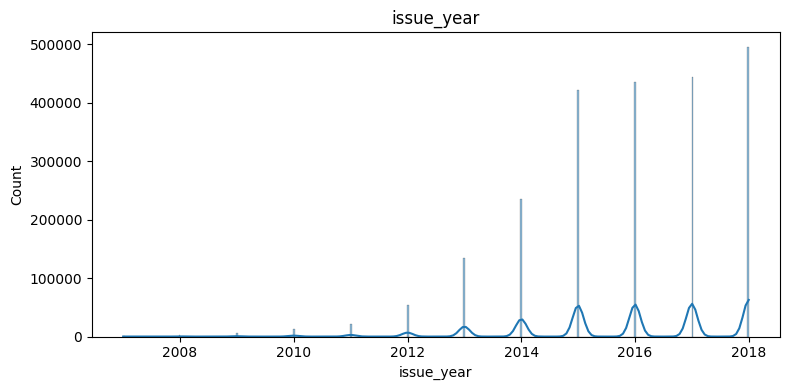

In [19]:
for col in minimal_clean_full_df.columns:
    plt.figure(figsize=(8, 4))
    plt.title(col)

    # Numeric columns
    if pd.api.types.is_numeric_dtype(minimal_clean_full_df[col]):
        sns.histplot(minimal_clean_full_df[col].dropna(), kde=True)
        plt.xlabel(col)

        # Categorical or text columns
    else:
        num_unique = minimal_clean_full_df[col].nunique()

        if num_unique <= 15:
            minimal_clean_full_df[col].value_counts().plot(kind="bar")
            plt.xlabel(col)
            plt.ylabel("Count")
        else:
            print(f"Skipping '{col}' (too many categories: {num_unique})")
            plt.close()
            continue

    plt.tight_layout()
    plt.show()

### parameter tuning

In [18]:
#checking the number of values from each column:
df_with_target = create_target(df_raw)
df_with_target["target_3class"].value_counts()

target_3class
paid_on_time    1788541
not_paid         261686
paid_late        210441
Name: count, dtype: int64

--- random forest ---

In [23]:
# 1. Load data
df_tuning = df.copy()

# 2. Create target
df_with_target_tuning = create_target(df_tuning)

# 3. Choose full or minimal clean
df_clean_tuning = minimal_clean(df_with_target_tuning)     # or minimal_clean(df_with_target)

# 4. Make balanced N-row dataset
def make_balanced_sample(df, N, target_col="target_3class", random_state=42):
    k = df[target_col].nunique()
    per_class = N // k

    balanced = (
        df.groupby(target_col)
          .apply(lambda g: g.sample(per_class, random_state=random_state))
          .reset_index(drop=True)
    )

    remaining = N - len(balanced)
    if remaining > 0:
        extra = df.sample(remaining, random_state=random_state)
        balanced = pd.concat([balanced, extra], ignore_index=True)

    return balanced

df_balanced_tuning = make_balanced_sample(df_clean_tuning, 100000)

# 5. Split into X and y
X = df_balanced_tuning.drop(columns=["target_3class"])
y = df_balanced_tuning["target_3class"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 6. Build preprocessing on X_train only
preprocess_tuning = make_preprocess(X_train)



C:\Users\tamar\AppData\Local\Temp\ipykernel_21616\2875091686.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(per_class, random_state=random_state))


In [25]:
rf_pipe_tuning = Pipeline([
    ("pre", preprocess_tuning),
    ("clf", RandomForestClassifier(
        random_state=42,
        n_jobs=-1
    ))
])

rf_pipe_tuning.fit(X_train, y_train)
y_pred = rf_pipe_tuning.predict(X_test)

baseline_f1 = f1_score(y_test, y_pred, average="macro")
print("Baseline Macro F1:", baseline_f1)

Baseline Macro F1: 0.6757124296798948


In [24]:
rf_params_coarse = {
    # We tune in phases so the computer can handle it. After deciding on each phase, moving on to the next one.

    # first:
    "clf__max_depth": [None, 10, 20, 30, 50],
    "clf__min_samples_leaf": [1, 2, 4, 8,16],
    "clf__n_estimators": [200, 400, 600, 800, 1200],


    # second
    "clf__max_features": ["sqrt", "log2", 0.2, 0.3, 0.5, 0.7, 1.0],
    "clf__n_estimators": [300, 500, 800],
    "clf__max_features": ["sqrt", "log2", 0.3, 0.5, 1.0],


    #third
    "clf__min_samples_split": [2, 5, 10, 20],
    "clf__class_weight": [None, "balanced"]
}

In [ ]:
rf_pipe = Pipeline([
    ("pre", preprocess_tuning),
    ("clf", RandomForestClassifier(random_state=42, n_jobs=-1))
])

rf_search_coarse = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=rf_params_coarse,
    n_iter=40,
    scoring="f1_macro",
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

rf_search_coarse.fit(X_train, y_train)

In [ ]:
print("Best coarse params:")
print(rf_search_coarse.best_params_)

print("Best CV f1_macro:")
print(rf_search_coarse.best_score_)

--- xg boost ---

In [29]:
y_train = y_train.astype("category").cat.codes
y_test = y_test.astype("category").cat.codes

In [30]:
xgb_pipe_tuning = Pipeline([
    ("pre", preprocess_tuning),
    ("clf", XGBClassifier(
        objective="multi:softprob",
        num_class=y.nunique(),
        eval_metric="mlogloss",
        tree_method="hist",
        random_state=42,
        n_jobs=-1
    ))
])

xgb_pipe_tuning.fit(X_train, y_train)
y_pred = xgb_pipe_tuning.predict(X_test)
baseline_xgb_f1 = f1_score(y_test, y_pred, average="macro")

print("Baseline XGB Macro F1:", baseline_xgb_f1)

Baseline XGB Macro F1: 0.7449341563021282


In [31]:
xgb_params_coarse = {
# We tune in phases so the computer can handle it. After deciding on each phase, moving on to the next one.

    #first
    "clf__n_estimators":        [200, 400, 800, 1200],
    "clf__learning_rate":       [0.01, 0.05, 0.1],
    "clf__max_depth":           [3, 7, 10, None],

    #second
    "clf__min_child_weight":    [1, 3, 5],
    "clf__subsample":           [0.6, 0.8, 1.0],
    "clf__colsample_bytree":    [0.6, 0.8, 1.0],
}

In [ ]:
xgb_search_coarse = RandomizedSearchCV(
    estimator=xgb_pipe_tuning,
    param_distributions=xgb_params_coarse,
    n_iter=40,
    scoring="f1_macro",
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

xgb_search_coarse.fit(X_train, y_train)

print("Best coarse params (XGB):")
print(xgb_search_coarse.best_params_)
print("Best CV f1_macro (XGB):")
print(xgb_search_coarse.best_score_)

--- logistic regression ---

In [32]:
from sklearn.linear_model import LogisticRegression

lr_pipe_tuning = Pipeline([
    ("pre", preprocess_tuning),
    ("clf", LogisticRegression(
        max_iter=2000,
        multi_class="multinomial",
        solver="lbfgs",
        n_jobs=-1
    ))
])

lr_pipe_tuning.fit(X_train, y_train)
y_pred = lr_pipe_tuning.predict(X_test)
baseline_lr_f1 = f1_score(y_test, y_pred, average="macro")

print("Baseline LR Macro F1:", baseline_lr_f1)

C:\Users\tamar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Baseline LR Macro F1: 0.7178864947612209


In [33]:
lr_params_coarse = {
# We tune in phases so the computer can handle it. After deciding on each phase, moving on to the next one.

    #first
    "clf__C":             [1e-3, 1e-2, 1e-1, 1, 5, 10],
    "clf__solver":       ["lbfgs", "saga"],
    "clf__penalty":      ["l2", "elasticnet"],

    #second
    "clf__l1_ratio":     [0.1, 0.3, 0.5, 0.7, 0.9],
    "clf__class_weight": [None, "balanced"],
    "clf__max_iter":     [1000, 2000, 4000],
}

In [ ]:
lr_search_coarse = RandomizedSearchCV(
    estimator=lr_pipe_tuning,
    param_distributions=lr_params_coarse,
    n_iter=40,
    scoring="f1_macro",
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

lr_search_coarse.fit(X_train, y_train)

print("Best coarse params (LR):")
print(lr_search_coarse.best_params_)
print("Best CV f1_macro (LR):")
print(lr_search_coarse.best_score_)

In [ ]:
df_full_sample["target_3class"].value_counts()
df_full_sample["target_3class"].value_counts(normalize=True)

In [ ]:
df_minimal_sample["target_3class"].value_counts()
df_minimal_sample["target_3class"].value_counts(normalize=True)